# Import libraries

In [1]:
import torch

import os
import random
import pandas
import numpy
import math
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# seed = 7777
# random.seed(seed) 
# torch.manual_seed(seed);

# Load Saved MP (Magnetic Parameter) Model

In [2]:
# 12 input -> 42 output
class MpModel(torch.nn.Module):
    def __init__(self):
        super(MpModel, self).__init__()

        self.linear1 = torch.nn.Linear(12, 100, bias=True)
        self.linear2 = torch.nn.Linear(100, 100, bias=True)
        self.linear3 = torch.nn.Linear(100, 42, bias=True)

    def forward(self, x):
        x = torch.atan(self.linear1(x))
        x = torch.atan(self.linear2(x))
        x = torch.atan(self.linear2(x))
        x = self.linear3(x)
        return x


mp_model = MpModel().to("cuda")
mp_model.load_state_dict(torch.load("saved_model_state.pt"))

for param in mp_model.parameters():
    param.requires_grad = False

# Create GP (Geometry Paramter) Generator

In [3]:
class GpModel(torch.nn.Module):
    def __init__(self, input_length: int):
        super(GpModel, self).__init__()

        self.dense_layer1 = torch.nn.Linear(int(input_length), 128)
        self.dense_layer2 = torch.nn.Linear(128, 256)
        # self.dense_layer3 = torch.nn.Linear(256, 512)
        # self.dense_layer4 = torch.nn.Linear(512, 256)
        self.dense_layer5 = torch.nn.Linear(256, 128)
        self.dense_layer6 = torch.nn.Linear(128, int(input_length))
        
        self.batch_norm1 = torch.nn.LazyBatchNorm1d()
        self.batch_norm2 = torch.nn.LazyBatchNorm1d()
        self.batch_norm3 = torch.nn.LazyBatchNorm1d()
        self.batch_norm4 = torch.nn.LazyBatchNorm1d()
        self.batch_norm5 = torch.nn.LazyBatchNorm1d()

    def forward(self, x):
        x = self.batch_norm1(torch.atan(self.dense_layer1(x)))
        x = self.batch_norm2(torch.atan(self.dense_layer2(x)))
        # x = self.batch_norm3(torch.atan(self.dense_layer3(x)))
        # x = self.batch_norm4(torch.atan(self.dense_layer4(x)))
        x = self.batch_norm5(torch.atan(self.dense_layer5(x)))
        x = torch.sigmoid(self.dense_layer6(x))
        return x


gp_model = GpModel(10).to("cuda")
optimizer = torch.optim.Adam(gp_model.parameters(), lr=3e-4)

C:\Users\arist\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# System Constraints

In [4]:
# x-direction of the primary winding (mm)
lpx_min, lpx_max = (50.0, 650.0)

# y-direction of the primary winding (mm)
lpy_min, lpy_max = (50.0, 2050.0)

# width of the primary winding (mm)
wp_min, wp_max = (25.0, 325.0)

# length of the edge of the primary core (mm)
a_min, a_max = (0.0, 200.0)

# pitch of the adjacent cores (mm)
p_min, p_max = (0.0, 200.0)

# length of the secondary winding (mm)
ls_min, ls_max = (50.0, 450.0)

# width of the secondary winding (mm)
ws_min, ws_max = (25.0, 225.0)

# input RMS current (A)
ip_min, ip_max = (50.0, 200.0)

# turn number of the primary side
np_min, np_max = (4.0, 10.0)

# turn number of the secondary side
ns_min, ns_max = (4.0, 10.0)

# switching frequency (kHz)
f = 85 * (10 ** 3)

# output power at the center (kW)
p_out = 50 * (10 ** 3)

# input DC voltage (V)
v_dc = 400

# output DC voltage (V)
v_bat = 400

# length of the edge of the secondary core
b = 50

# ???
w = 2 * numpy.pi * f  # [rad/s]

# ???
q_coil = 400

# Helper functions

In [5]:
# Creates a tensor of shape [num, *start.shape] whose values are evenly spaced from start to end, inclusive.
# Replicates but the multi-dimensional bahaviour of numpy.linspace in PyTorch.

@torch.jit.script
def linspace(start: torch.Tensor, stop: torch.Tensor, num: int):
    # create a tensor of 'num' steps from 0 to 1
    steps = torch.arange(num, dtype=torch.float32, device=start.device) / (num - 1)

    # reshape the 'steps' tensor to [-1, *([1]*start.ndim)] to allow for broadcastings
    # - using 'steps.reshape([-1, *([1]*start.ndim)])' would be nice here but torchscript
    #   "cannot statically infer the expected size of a list in this contex", hence the code below
    for i in range(start.ndim):
        steps = steps.unsqueeze(-1)

    # the output starts at 'start' and increments until 'stop' in each dimension
    out = start[None] + steps * (stop - start)[None]

    return out

In [6]:
# Generate a pytorch tensor full of random floats in the range [-1, +1] with the given shape

def generate_noise(shape):
    return torch.distributions.uniform.Uniform(-1, +1).sample(shape).cuda()

In [7]:
def stack_parameters(*params):
    return torch.stack(params).transpose(0, 1)


# Scale an array to be between our specified [min, max] contraints
def scale(arr):
    scaler_min = torch.tensor(
        [a_min, lpx_min, lpy_min, ls_min, p_min, wp_min, ws_min, ip_min, np_min, ns_min],
        device="cuda",
    )
    scaler_max = torch.tensor(
        [a_max, lpx_max, lpy_max, ls_max, p_max, wp_max, ws_max, ip_max, np_max, ns_max],
        device="cuda",
    )

    return arr * (scaler_max - scaler_min) + scaler_min


def extract(arr):
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns = [
        numpy.squeeze(x) for x in numpy.hsplit(arr, 10)
    ]

    ys_min = (
        5 * wp +
        4 * a +
        3 * lpy +
        2 * p
    )

    ys_max = (lpy + wp)
    ys_max = ys_min + (ys_min - ys_max) / 2

    ys_min /= 2
    ys_max /= 2

    ys = linspace(ys_min, ys_max, num=5)

    np = torch.round(np)
    ns = torch.round(ns)

    # take all 15 tensors of shape (X) and convert to (15, X)
    return a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys


def scale_and_extract(arr):
    scaled_array = scale(arr)
    return extract(scaled_array)

In [8]:
# Enclose in a function so we don't leak variables
def test_models():
    noise = generate_noise(shape=(256, 10))
    gp = gp_model(noise)
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)

    gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
    extra_parameters = stack_parameters(ip, np, ns)

    mp = mp_model(gp_parameters)

    print(f"""
    GP Parameters Shape:    {gp_parameters.shape}
    Extra Parameters Shape: {extra_parameters.shape}
    MP Model Output Shape:  {mp.shape}
    """)
test_models()


    GP Parameters Shape:    torch.Size([256, 12])
    Extra Parameters Shape: torch.Size([256, 3])
    MP Model Output Shape:  torch.Size([256, 42])
    


In [9]:
"""
Method to take two equally-sized lists and return just the elements which lie 
on the Pareto frontier, sorted into order.
Default behaviour is to find the maximum for both X and Y, but the option is
available to specify maxX = False or maxY = False to find the minimum for either
or both of the parameters.
"""


def pareto_frontier(x, y, max_x=False):
    if max_x:
        return _pareto_frontier(y, x)
    else:
        return _pareto_frontier(x, y)


def _pareto_frontier(x, y):
    # Combine inputs and sort them with smallest X values coming first
    sorted_xy = sorted(zip(x, y))
    p_front_x = torch.zeros(len(x), device="cuda")
    p_front_y = torch.zeros(len(y), device="cuda")
    
    # Loop through the sorted list
    #   Look for lower values of Y…
    #   and add them to the Pareto frontier
    min_y = sorted_xy[0][1]
    for index in range(len(sorted_xy)):
        x, y = sorted_xy[index]
        if y < min_y:
            min_y = y
            p_front_x[index] = x
            p_front_y[index] = y
            
    p_front_x = p_front_x[p_front_x.nonzero()]
    p_front_y = p_front_y[p_front_y.nonzero()]

    return p_front_x, p_front_y

In [10]:
#testing for creating total pareto f

def oldgraph_pareto_frontier(Xs, Ys, maxX = False, maxY = False):
# Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
# Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]    
# Loop through the sorted list
    for pair in myList[1:]:
        if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
            p_front.append(pair) # … and add them to the Pareto frontier
# Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

In [11]:
def findSpline(x, y, smoothing_factor = 2):
    spl = UnivariateSpline(x, y)
    spl.set_smoothing_factor(smoothing_factor)
    return spl

In [12]:
def pair_loss_calc(x, y, x_numpy, y_numpy, pareto_x_numpy, pareto_y_numpy, pareto_x_forx_numpy, pareto_y_forx_numpy):
    if len(pareto_y_numpy) > 3:
        # f = interp1d(pareto_bstray_numpy[:,0], pareto_kdiff_numpy[:,0])
        # f2 = interp1d(pareto_bstray_numpy[:,0], pareto_kdiff_numpy[:,0], kind = 'cubic')
        # plt.plot(pareto_bstray_numpy[:,0], f2(pareto_bstray_numpy[:,0]), '--', pareto_bstray_numpy, pareto_kdiff_numpy, 'o')


        spl_y = findSpline(pareto_x_numpy[:,0], pareto_y_numpy[:,0])
        y_calc = torch.as_tensor(spl_y(x_numpy)).cuda()
        # plt.plot(pareto_bstray_numpy[:,0], spl_y(pareto_bstray_numpy[:,0]), '--', pareto_bstray_fory_numpy, pareto_kdiff_fory_numpy, 'o')
        # plt.show()
        y_loss = y - y_calc
        y_loss_relu = torch.nn.functional.relu(y_loss)


        spl_x = findSpline(pareto_y_forx_numpy[:,0], pareto_x_forx_numpy[:,0])
        # plt.plot(spl_x(pareto_kdiff_fory_numpy[:,0]), pareto_kdiff_fory_numpy[:,0], '--', pareto_bstray_fory_numpy, pareto_kdiff_fory_numpy,  'o')
        # plt.show()


        x_calc = torch.as_tensor(spl_x(y_numpy)).cuda()
        x_loss = x - x_calc
        x_loss_relu = torch.nn.functional.relu(x_loss)
       

    if len(pareto_x_numpy) > 3 and len(pareto_y_numpy) > 3:
        combined_loss = torch.sum(y_loss_relu * x_loss_relu)
    else: 
        combined_loss = torch.zeros(1, requires_grad=True, device = "cuda")
        # print('No new pareto points found, used zero grad')
    
    
    return combined_loss

In [13]:
def compute_pairloss_and_pareto(x, y):
    
    pareto_x, pareto_y = pareto_frontier(x, y)
    pareto_y_forx, pareto_x_forx = pareto_frontier(y, x)
    
    pareto_x_numpy = pareto_x.cpu().data.numpy()
    pareto_y_numpy = pareto_y.cpu().data.numpy()
    
    pareto_x_forx_numpy = pareto_x_forx.cpu().data.numpy()
    pareto_y_forx_numpy = pareto_y_forx.cpu().data.numpy()
    
    x_numpy = x.cpu().data.numpy()
    y_numpy = y.cpu().data.numpy()
    
    x_y_loss = pair_loss_calc(x, y, x_numpy, y_numpy, pareto_x_numpy, pareto_y_numpy, pareto_x_forx_numpy, pareto_y_forx_numpy)
    
    return x_y_loss, pareto_x, pareto_y, x_numpy, y_numpy, pareto_x_numpy, pareto_y_numpy, pareto_x_forx_numpy, pareto_y_forx_numpy

In [14]:
def pave_tomax(pavemin, pave_max_value=500):
    pave_max = torch.sub(pave_max_value, pavemin)
    return pave_max

# Load DWPT data

In [15]:
def load_dwpt():
    folder_name = "./dwpt_v5"
    file_names = [
        "DWPT_v5_N10",
        "DWPT_v5_N100",
        "DWPT_v5_N200",
        "DWPT_v5_N300",
        "DWPT_v5_N400",
    ]

    df = pandas.DataFrame()

    for file_name in file_names:
        new_df = pandas.read_csv(f"{folder_name}/{file_name}_after.csv", index_col=0)
        df = pandas.concat([df, new_df])

    return df

df = load_dwpt()
df_gp = df.loc[:, :"ys4[mm]"]
df_mp = df.loc[:, "k0mm_ys0":]

print(df_gp.shape)
print(df_mp.shape)

(1010, 12)
(1010, 42)


# Define Loss Functions

In [16]:
import math
f = 85*10**3 #[Hz]
w =2*math.pi*f #[rad/s]
Pout= 50000 #W
Vdc = 400 #800 # V
Vbat = 400 #V
QCoil = 400
b = 50

In [17]:
def kdiff_loss(k_parameters):
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters

    kdiff = abs(k_0_0 - k_1_0)
    kdiff = kdiff / torch.max(abs(k_0_0), abs(k_1_0))

    return kdiff

def calculate_Is(l_parameters, k_parameters):
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters
    (
        lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
        ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
        lp_1_0, ls_1_0,
    ) = l_parameters

    a6 = lp_0_0 * np ** 2
    a11 = ls_0_0 * ns ** 2
  # Paper formula
    n1 = (torch.pi * w * a6 * ip) / (2*numpy.sqrt(2) * v_dc)
    t1 = (torch.pi ** 2 * w * p_out * torch.sqrt(a6 * a11))
    t2 = 8 * k_0_0 * n1 * v_dc * v_bat
    n2 = t1 / t2
    Is = (4 * v_bat * n2) / (torch.pi * w * a11)

    return Is
  
def bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters):
    # Unpack parameters
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters
    (
        lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
        ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
        lp_1_0, ls_1_0,
    ) = l_parameters
    (
        bx_p_0_00, by_p_0_00, bz_p_0_00,
        bx_p_0_90, by_p_0_90, bz_p_0_90,
        bx_s_0_00, by_s_0_00, bz_s_0_00,
        bx_s_0_90, by_s_0_90, bz_s_0_90,

        bx_p_1_00, by_p_1_00, bz_p_1_00,
        bx_p_1_90, by_p_1_90, bz_p_1_90,
        bx_s_1_00, by_s_1_00, bz_s_1_00,
        bx_s_1_90, by_s_1_90, bz_s_1_90,
    ) = b_parameters
    (
        ip, np, ns
    ) = extra_parameters

    Is = calculate_Is(l_parameters,k_parameters)

    bx_100 = (
        (bx_p_1_00 * ip * np + bx_s_1_00 * Is * ns) ** 2 +
        (bx_p_1_90 * ip * np + bx_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    by_100 = (
        (by_p_1_00 * ip * np + by_s_1_00 * Is * ns) ** 2 +
        (by_p_1_90 * ip * np + by_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    bz_100 = (
        (bz_p_1_00 * ip * np + bz_s_1_00 * Is * ns) ** 2 +
        (bz_p_1_90 * ip * np + bz_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    b_100 = (bx_100**2 + by_100**2 + bz_100**2) ** 0.5

    bstray = b_100

    return bstray

In [20]:
def power_average(k_parameters, l_parameters, b_parameters, extra_parameters, gp_parameters):
  
  return 

In [21]:
def number_of_inverters(gp_parameters):
    (
        a, lpx, lpy, ls, p, wp, ws, *ys
    ) = gp_parameters.clone().transpose(0,1)
    
    number_of_inverters = 1/(lpy+2*wp+2*a+p)*10**3

    return number_of_inverters

In [22]:
def core_losses(extra_parameters, gp_parameters):
    (
        ip, np, ns
    ) = extra_parameters

    (
        a, lpx, lpy, ls, p, wp, ws, *ys
    ) = gp_parameters.transpose(0,1)
    
    V_PriCore = ((lpy +2*wp+2*a)*(lpx+2*wp+2*a)*5)/(10**3) # cm3
    V_SecCore = (((ls+2*ws+2*b)**2)*5)/(10**3)
    V_PriWind = (2*(lpx+wp)+2*(lpy+wp))*6.6*6.6/(10**3)*np
    V_SecWind = 4*(ls+ws)*6.6*6.6/(10**3)*ns

    return V_PriCore, V_SecCore, V_PriWind, V_SecWind

In [25]:
def calculate_coilloss_pave(k_parameters, l_parameters, b_parameters, extra_parameters):
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters
    (
        lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
        ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
        lp_1_0, ls_1_0,
    ) = l_parameters
    (
        bx_p_0_00, by_p_0_00, bz_p_0_00,
        bx_p_0_90, by_p_0_90, bz_p_0_90,
        bx_s_0_00, by_s_0_00, bz_s_0_00,
        bx_s_0_90, by_s_0_90, bz_s_0_90,

        bx_p_1_00, by_p_1_00, bz_p_1_00,
        bx_p_1_90, by_p_1_90, bz_p_1_90,
        bx_s_1_00, by_s_1_00, bz_s_1_00,
        bx_s_1_90, by_s_1_90, bz_s_1_90,
    ) = b_parameters
    (
        ip, np, ns
    ) = extra_parameters


    a6 = lp_0_0 * np**2  # LP0MM_YSO
    a7 = lp_0_1 * np**2  # LP0MM_YS1
    a8 = lp_0_2 * np**2  # LP0MM_YS2
    a9 = lp_0_3 * np**2  # LP0MM_YS3
    a10 = lp_0_4 * np**2 # LP0MM_YS4

    a11 = ls_0_0 * ns**2 # LS0MM_YSO
    a12 = ls_0_1 * ns**2 # LS0MM_YS1
    a13 = ls_0_2 * ns**2 # LS0MM_YS2
    a14 = ls_0_3 * ns**2 # LS0MM_YS3
    a15 = ls_0_4 * ns**2 # LS0MM_YS4

    Is = calculate_Is_test_2(l_parameters,k_parameters)
  
    loss = (w*a6*10**(-9)*ip**2/QCoil + w*a11*10**(-9)*Is**2/QCoil) 

    p0 = w*k_0_0*(a6 * a11)**0.5*ip*Is
    p1 = w*k_0_1*(a7 * a12)**0.5*ip*Is
    p2 = w*k_0_2*(a8 * a13)**0.5*ip*Is
    p3 = w*k_0_3*(a9 * a14)**0.5*ip*Is
    p4 = 2*w*k_0_4*(a10 * a15)**0.5*ip*Is
    pave = (p0+(2*p1)+(2*p2)+(2*p3)+ p4)/8
    pave_kW = pave / 1000

    return loss,pave_kW

# Neural Network Training Loop

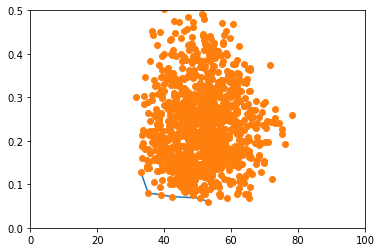

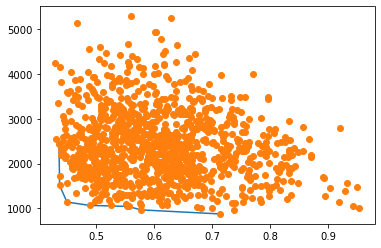

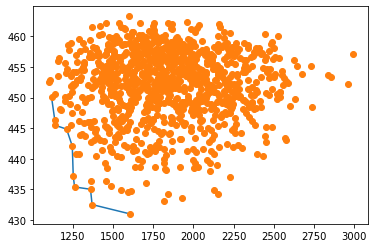

Epoch:    0
  Kdiff :         23.5755%
  Bstray :        51.4322
  Pareto Kdiff :  5.9767%
  Pareto Bstray : 52.9604
  Coilloss :      2427.9536
  num inv :        0.6104
  Pareto Coilloss : 877.9530
  Pareto num inv : 0.4307
  V_SecCore :  1838.8491
  pave : 48.0044


C:\Users\arist\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


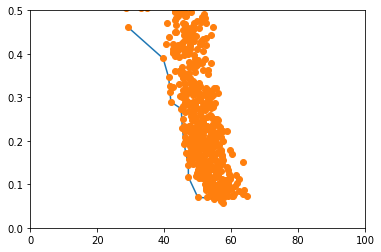

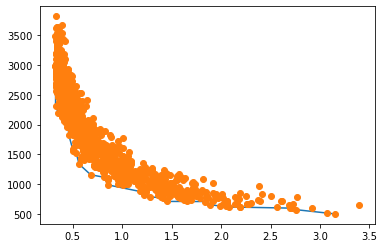

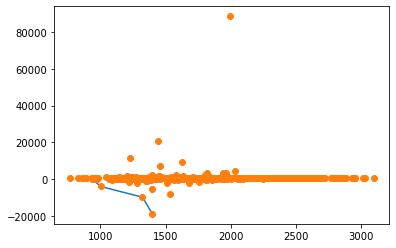

Epoch:   50
  Kdiff :         62.5420%
  Bstray :        51.4322
  Pareto Kdiff :  5.6302%
  Pareto Bstray : 57.6606
  Coilloss :      1881.5154
  num inv :        0.6104
  Pareto Coilloss : 500.3254
  Pareto num inv : 0.3253
  V_SecCore :  1824.6876
  pave : -22.1071


C:\Users\arist\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
C:\Users\arist\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


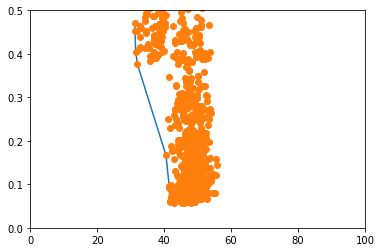

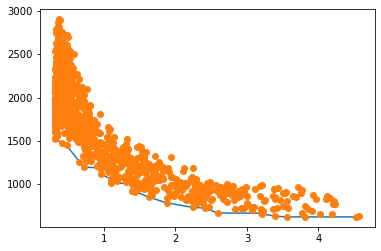

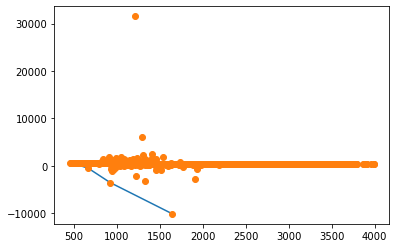

Epoch:  100
  Kdiff :         51.1690%
  Bstray :        51.4322
  Pareto Kdiff :  5.6244%
  Pareto Bstray : 43.0439
  Coilloss :      1683.3733
  num inv :        0.6104
  Pareto Coilloss : 622.4586
  Pareto num inv : 0.3167
  V_SecCore :  1886.3834
  pave : -0.0129


C:\Users\arist\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


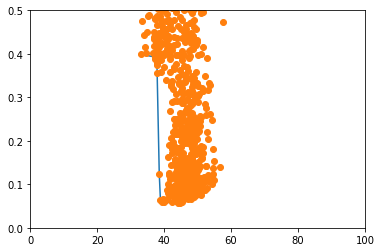

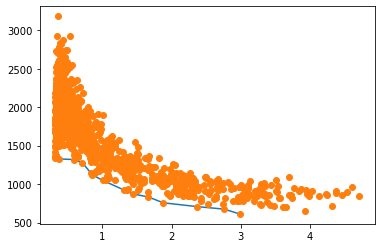

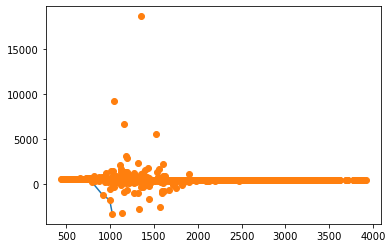

Epoch:  150
  Kdiff :         51.8642%
  Bstray :        51.4322
  Pareto Kdiff :  5.5912%
  Pareto Bstray : 44.1153
  Coilloss :      1664.8450
  num inv :        0.6104
  Pareto Coilloss : 612.3871
  Pareto num inv : 0.3132
  V_SecCore :  1894.5220
  pave : 6.2520


C:\Users\arist\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [26]:
pareto_bstray_points = []
pareto_kdiff_points = []
pareto_numinv_points = []
pareto_coilloss_points = []
pareto_V_SecCore_points = []
pareto_pave_post_points = []

kdiffs = []
bstrays = []
numinvs = []
coillosses = []
combined_losses = []

#testing for graphs
kdiff_designs = []
bstray_designs = []
numinv_designs = []
coilloss_designs = []
V_SecCore_designs = []
pave_designs = []

pareto_bstray_points2 = []
pareto_kdiff_points2 = []

x_calc_numpy =[]
y_calc_numpy=[]

#training parameters
n_epochs = 200
n_noise = 1000

for epoch in range(n_epochs):
    
    # Clear old gradients in the GP model
    for param in gp_model.parameters():
        param.grad = None

    # Create GP parameters from noise
    noise = generate_noise(shape=(n_noise, 10))
    gp = gp_model(noise)

    # Unpack and filter GP parameters
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
    gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
    extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

    V_PriCore, V_SecCore, V_PriWind,V_SecWind = core_losses(extra_parameters,gp_parameters)
    numinv = number_of_inverters(gp_parameters)
    
    # Scale GP parameters - why?
    min_x = torch.min(gp_parameters)
    max_x = torch.max(gp_parameters)
    gp_parameters = (gp_parameters - min_x) / (max_x - min_x)
  
    # Push GP parameters through MP model
    mp_parameters = mp_model(gp_parameters)

    # Scale MP parameters
    y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
    min_y = torch.min(y, 1).values
    max_y = torch.max(y, 1).values
    mp_parameters = mp_parameters * (max_y - min_y) + min_y

    k_parameters = mp_parameters.transpose(0, 1)[0:6]
    l_parameters = mp_parameters.transpose(0, 1)[6:18]
    b_parameters = mp_parameters.transpose(0, 1)[18:]

    # Calculate losses
    kdiff = kdiff_loss(k_parameters)
    bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)
    # coilloss,pave = coil_loss_and_power_average(k_parameters, l_parameters, b_parameters, extra_parameters)
    # print(pave)
    coilloss,pave = coilloss_pave_test_2(k_parameters, l_parameters, b_parameters, extra_parameters)
    
    #pmax - pave_kW, to get tensor to minimize, pavemin is tensor to minimize
    pavemin = torch.sub(500, pave)

    # Call pairwise pareto and loss
    bstray_kdiff_loss, pareto_bstray, pareto_kdiff, bstray_numpy, kdiff_numpy, pareto_bstray_numpy, pareto_kdiff_numpy, pareto_bstray_forx_numpy, pareto_kdiff_forx_numpy = compute_pairloss_and_pareto(bstray, kdiff)
    numinv_coilloss_loss, pareto_numinv, pareto_coilloss, numinv_numpy, coilloss_numpy, pareto_numinv_numpy, pareto_coilloss_numpy, pareto_numinv_forx_numpy, pareto_coilloss_forx_numpy = compute_pairloss_and_pareto(numinv, coilloss)
    V_SecCore_pavemin_loss, pareto_V_SecCore, pareto_pavemin, V_SecCore_numpy, pavemin_numpy, pareto_V_SecCore_numpy, pareto_pavemin_numpy, pareto_V_SecCore_forx_numpy, pareto_pavemin_forx_numpy = compute_pairloss_and_pareto(V_SecCore, pavemin)
    
    #get pave points for plotting
    pareto_pave_post = pave_tomax(pareto_pavemin)
    
    #combine pairwise losses
    combined_loss = (bstray_kdiff_loss + numinv_coilloss_loss + V_SecCore_pavemin_loss)

    # Push loss through the optimizer and update the GP model
    try:
        combined_loss.backward(retain_graph=True)
        optimizer.step()
    except Exception as e:
        print(f"Error on epoch {epoch} regarding", e)
        break

    
    if epoch % 50 == 0:
        
        # plt.plot(pareto_bstray_numpy[:,0], spl_y(pareto_bstray_numpy[:,0]), '--', bstray_numpy, kdiff_numpy, 'o')
        plt.plot(pareto_bstray_numpy, pareto_kdiff_numpy)
        plt.plot(bstray_numpy, kdiff_numpy, 'o')
        # plt.plot(x_calc.cpu().data.numpy(), kdiff_numpy, 'o')
        plt.xlim([0,100])
        plt.ylim([0,0.5])
        plt.show()
        
        plt.plot(pareto_numinv_numpy, pareto_coilloss_numpy)
        plt.plot(numinv_numpy, coilloss_numpy, 'o')
        plt.show()
        
        plt.plot(pareto_V_SecCore_numpy, pareto_pavemin_numpy)
        plt.plot(V_SecCore_numpy, pavemin_numpy, 'o')
        plt.show()

        #paretopoints graphing test
        pareto_bstray_test, pareto_kdiff_test = oldgraph_pareto_frontier(bstray.cpu().detach().numpy(), kdiff.cpu().detach().numpy())
        pareto_bstray_points2.append(pareto_bstray_test)
        pareto_kdiff_points2.append(pareto_kdiff_test)

        # Store metrics for plotting or further logging
        combined_losses.append(combined_loss.cpu().data.numpy())
        kdiffs.append(torch.mean(kdiff).cpu().data.numpy())
        bstrays.append(torch.mean(bstray).cpu().data.numpy())
        numinvs.append(torch.mean(numinv).cpu().data.numpy())
        coillosses.append(torch.mean(coilloss).cpu().data.numpy())
        
        kdiff_designs.append(kdiff.cpu().data.numpy())
        bstray_designs.append(bstray.cpu().data.numpy())
        numinv_designs.append(numinv.cpu().data.numpy())
        coilloss_designs.append(coilloss.cpu().data.numpy())
        V_SecCore_designs.append(V_SecCore_numpy)
        pave_designs.append(pave.cpu().data.numpy())
        
        
        pareto_bstray_points.append(pareto_bstray[:].cpu().detach().numpy())
        pareto_kdiff_points.append(pareto_kdiff[:].cpu().detach().numpy())
        pareto_numinv_points.append(pareto_numinv[:].cpu().detach().numpy())
        pareto_coilloss_points.append(pareto_coilloss[:].cpu().detach().numpy())
        pareto_V_SecCore_points.append(pareto_V_SecCore[:].cpu().detach().numpy())
        pareto_pave_post_points.append(pareto_pave_post[:].cpu().detach().numpy())


        print(f"Epoch: {epoch:4d}")
        # print(f"  Combined Loss:  {combined_losses[-1]:.10f}")
        print(f"  Kdiff :         {100 * kdiffs[-1]:.4f}%")
        print(f"  Bstray :        {bstrays[0]:.4f}")
        print(f"  Pareto Kdiff :  {100 * torch.mean(pareto_kdiff[-1]):.4f}%")
        print(f"  Pareto Bstray : {torch.mean(pareto_bstray[-1]):.4f}")
        print(f"  Coilloss :      {coillosses[-1]:.4f}")
        print(f"  num inv :        {numinvs[0]:.4f}")
        print(f"  Pareto Coilloss : {torch.mean(pareto_coilloss[-1]):.4f}")
        print(f"  Pareto num inv : {torch.mean(pareto_numinv[0]):.4f}")    
        print(f"  V_SecCore :  {torch.mean(V_SecCore).cpu().data.numpy():.4f}")
        print(f"  pave : {torch.mean(pave).cpu().data.numpy():.4f}")
        

        # Save model for further training or testing
        torch.save(gp_model, f"./models/gp_model_{epoch:06}.pt")

# Plotting

In [27]:
#use inside every so many epoch printing          


# figure, axis = plt.subplots(2, 1, figsize=(10,10))
#         plt.figure(figsize=(10, 5))
        
#         if normalize == True:
#             axis[0].plot(normalized_pareto_bstray_numpy, normalized_pareto_kdiff_numpy)
#             axis[0].scatter(x_calc.cpu().data.numpy(), normalized_kdiff_numpy)
#             axis[0].scatter(normalized_bstray_numpy, normalized_kdiff_numpy)
#             axis[0].set_xlim([0,1])
#             axis[0].set_ylim([0,1])
#             axis[0].set_xlabel("Bstray")
#             axis[0].set_ylabel("Kdiff %")
#             axis[0].set_title(f"x_calc vs. designs, epoch: {epoch}")
            
#             axis[1].plot(normalized_pareto_bstray_numpy, normalized_pareto_kdiff_numpy)
#             axis[1].scatter(normalized_bstray_numpy, y_calc.cpu().data.numpy())
#             axis[1].scatter(normalized_bstray_numpy, normalized_kdiff_numpy)
#             axis[1].set_xlim([0,1])
#             axis[1].set_ylim([0,1])
#             axis[1].set_xlabel("Bstray")
#             axis[1].set_ylabel("Kdiff %")
#             axis[1].set_title(f"y_calc vs. designs, epoch: {epoch}")
#         else:
#             axis[0].plot(pareto_bstray_numpy, pareto_kdiff_numpy)
#             axis[0].scatter(x_calc.cpu().data.numpy(), kdiff_numpy)
#             axis[0].scatter(bstray_numpy, kdiff_numpy)
#             axis[0].set_xlim([0,100])
#             axis[0].set_ylim([0,1])
#             axis[0].set_xlabel("Bstray")
#             axis[0].set_ylabel("Kdiff %")
#             axis[0].set_title(f"x_calc vs. designs, epoch: {epoch}")
            
#             axis[1].plot(pareto_bstray_numpy, pareto_kdiff_numpy)
#             axis[1].scatter(bstray_numpy, y_calc.cpu().data.numpy())
#             axis[1].scatter(bstray_numpy, kdiff_numpy)
#             axis[1].set_xlim([0,100])
#             axis[1].set_ylim([0,1])
#             axis[1].set_xlabel("Bstray")
#             axis[1].set_ylabel("Kdiff %")
#             axis[1].set_title(f"y_calc vs. designs, epoch: {epoch}")
            
            
        # plt.xlim([0,100])
        # plt.ylim([0,0.5])
        # plt.show()

4
4
12 12


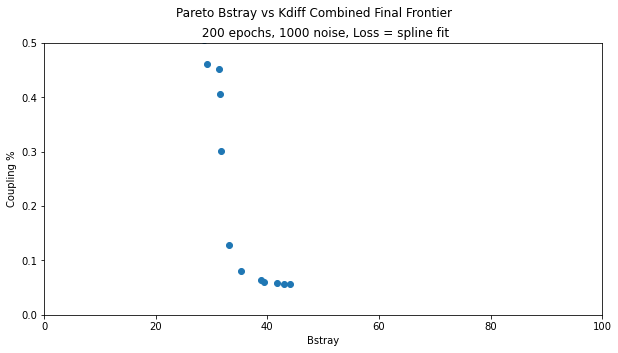

In [28]:
#scatter plot of final pareto points
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Bstray vs Kdiff Combined Final Frontier")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.5])

print(len(pareto_bstray_points2[:]))
print(len(pareto_kdiff_points2[:]))
# print(pareto_bstray_points2[:])
final_x = []
for list in pareto_bstray_points2:
    for item in list:
        final_x.append(item)


final_y = []
for list in pareto_kdiff_points2:
    for item in list:
        final_y.append(item)

final_x, final_y = oldgraph_pareto_frontier(final_x, final_y)
print(len(final_x),len(final_y))

plt.scatter(final_x, final_y)
plt.show() 

4
4
12 12


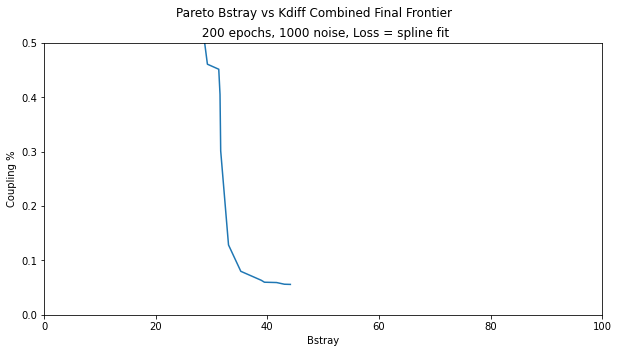

In [29]:
#line plot of final pareto points

plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Bstray vs Kdiff Combined Final Frontier")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.50])

print(len(pareto_bstray_points2[:]))
print(len(pareto_kdiff_points2[:]))
# print(pareto_bstray_points2[:])
final_x = []
for list in pareto_bstray_points2:
    for item in list:
        final_x.append(item)


final_y = []
for list in pareto_kdiff_points2:
    for item in list:
        final_y.append(item)

final_x, final_y = oldgraph_pareto_frontier(final_x, final_y)
print(len(final_x),len(final_y))

plt.plot(final_x, final_y)
plt.show() 

4 4


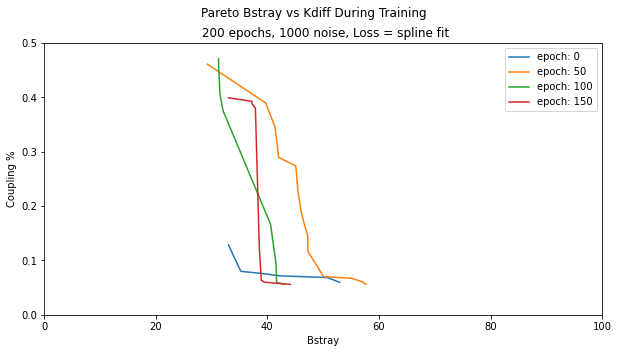

'\nplt.figure(figsize=(10, 5))\nplt.title(f"Pareto Kdiff During Training")\nplt.xlabel("Epoch")\nplt.ylabel("Coupling %")\n\nfor x in pareto_kdiff_points:\n    plt.plot(x)\nplt.show()\n'

In [30]:
i = 0
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Bstray vs Kdiff During Training")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.50])

print(len(pareto_bstray_points), len(pareto_kdiff_points))

while i < len(pareto_bstray_points):
    plt.plot(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*50}")
    # plt.plot(pareto_bstray_points[i], pareto_kdiff_points[i])
    i+=1
plt.legend()
plt.savefig('Pareto_Bstray_Kdiff_1000Epoch_256Noise_linfit.png')
plt.show()


'''
plt.figure(figsize=(10, 5))
plt.title(f"Pareto Kdiff During Training")
plt.xlabel("Epoch")
plt.ylabel("Coupling %")

for x in pareto_kdiff_points:
    plt.plot(x)
plt.show()
'''

4 4


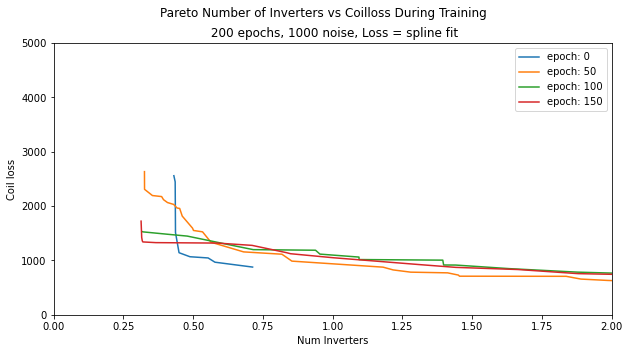

In [31]:
i = 0
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Number of Inverters vs Coilloss During Training")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")
plt.xlabel("Num Inverters")
plt.ylabel("Coil loss")
plt.xlim([0,2])
plt.ylim([0, 5000])

print(len(pareto_numinv_points), len(pareto_coilloss_points))

while i < len(pareto_numinv_points):
    plt.plot(pareto_numinv_points[i], pareto_coilloss_points[i], label = f"epoch: {i*50}")
    # plt.plot(pareto_bstray_points[i], pareto_kdiff_points[i])
    i+=1
plt.legend()
# plt.savefig('Pareto_Bstray_Kdiff_1000Epoch_256Noise_linfit.png')
plt.show()

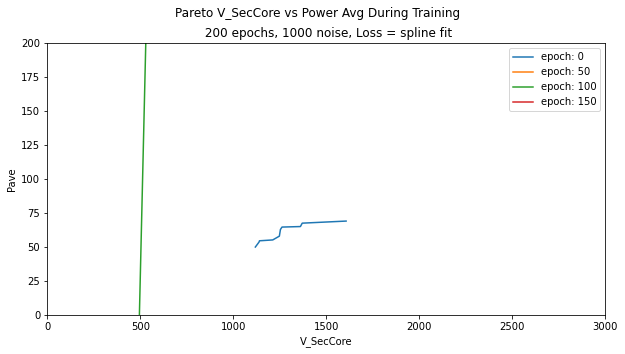

In [32]:
i = 0
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto V_SecCore vs Power Avg During Training")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")
plt.xlabel("V_SecCore")
plt.ylabel("Pave")
plt.xlim([0,3000])
plt.ylim([0, 200])

while i < len(pareto_V_SecCore_points):
    plt.plot(pareto_V_SecCore_points[i], pareto_pave_post_points[i], label = f"epoch: {i*50}")
    # plt.plot(pareto_bstray_points[i], pareto_kdiff_points[i])
    i+=1
plt.legend()
# plt.savefig('Pareto_Bstray_Kdiff_1000Epoch_256Noise_linfit.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4 4


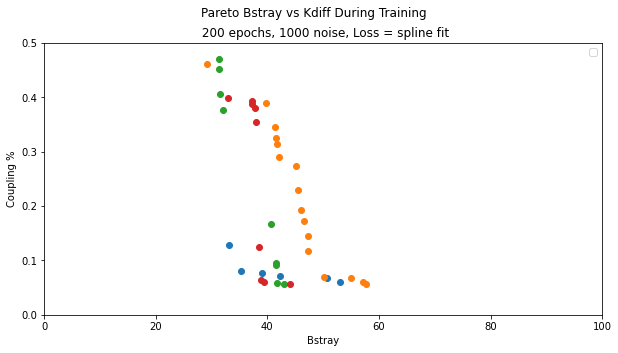

In [33]:
i = 0
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Bstray vs Kdiff During Training")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.50])

print(len(pareto_bstray_points), len(pareto_kdiff_points))

while i < len(pareto_bstray_points):
    #plt.scatter(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*100}")
    plt.scatter(pareto_bstray_points[i], pareto_kdiff_points[i])
    i+=1
plt.legend()
plt.savefig('Pareto_Bstray_Kdiff_1000Epoch_256Noise_linfit.png')
plt.show()

4


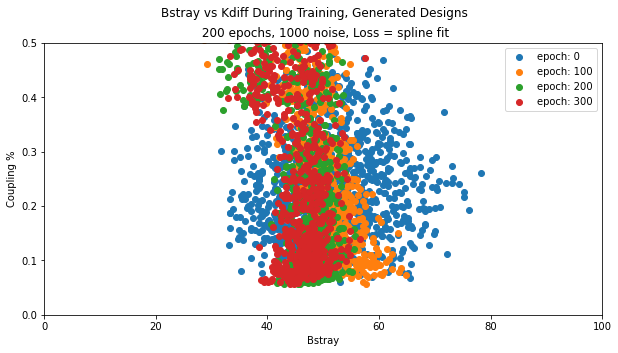

In [34]:
i = 0
print(len(bstray_designs))
#colors = numpy.arange(len(bstray_designs))
colors = numpy.arange(1000)
plt.figure(figsize=(10, 5))
plt.suptitle(f"Bstray vs Kdiff During Training, Generated Designs")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.50])

while i < len(bstray_designs):
    #plt.scatter(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*100}")
    #fig = plt.scatter(bstray_designs[i], kdiff_designs[i],c=i, cmap='viridis')
    fig = plt.scatter(bstray_designs[i], kdiff_designs[i], label = f"epoch: {i*100}")
    i+=1
    
# plt.colorbar()
plt.legend()
# from matplotlib.patches import Rectangle
# someX, someY = 45, 0.5
# fig,ax = plt.subplots()
# currentAxis = plt.gca()
# currentAxis.add_patch(Rectangle((someX -0.1, someY-0.1), 0.2, 0.2, alpha=0.5, facecolor='red'))
#plt.savefig('Bstray_Kdiff_1000Epoch_256Noise_linfit.png')
plt.show()

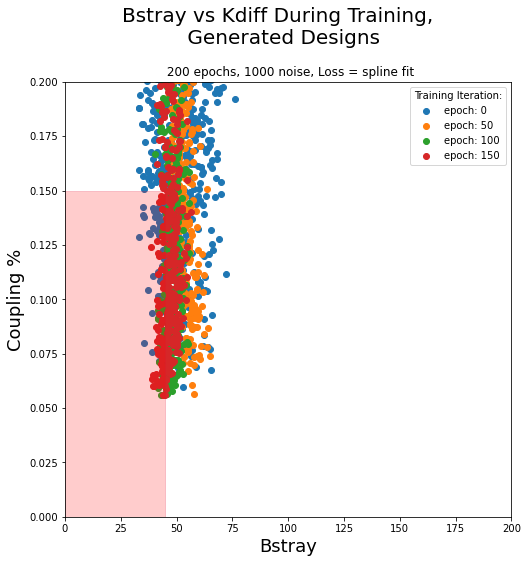

<Figure size 576x576 with 0 Axes>

In [42]:
i = 0
fig, ax = plt.subplots()

while i < len(bstray_designs):
    #plt.scatter(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*100}")
    #fig = plt.scatter(bstray_designs[i], kdiff_designs[i],c=i, cmap='viridis')
    ax.scatter(bstray_designs[i], kdiff_designs[i], label = f"epoch: {i*50}")
    i+=1

plt.xlim(0,200)
plt.ylim(0, 0.2)
plt.legend(title='Training Iteration:')
plt.xlabel("Bstray", fontsize = 18)
plt.ylabel('Coupling %', fontsize = 18)
plt.suptitle(f"Bstray vs Kdiff During Training, \n Generated Designs" , fontsize = 20, y=1.01)
# plt.title(f" {n_epochs} epochs, {n_noise} noise, normalized:{normalize}, Loss = curve fit with {chosen_curve_util.__name__}")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")

rect = patches.Rectangle(( 0,0 ), 45, 0.15, alpha = 0.2, ec = "Crimson", fc = "Red", visible = True)
ax.add_patch(rect)
plt.rcParams["figure.figsize"] = (8,8)
plt.figure(figsize=(8, 8))
plt.show()

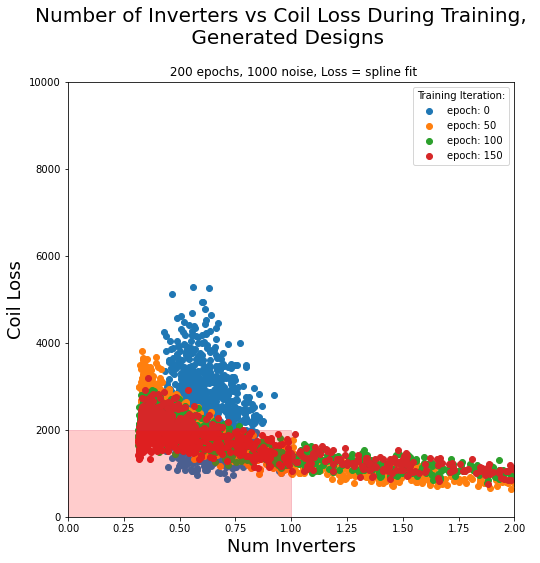

<Figure size 576x576 with 0 Axes>

In [43]:
i = 0
fig, ax = plt.subplots()

while i < len(numinv_designs):
    #plt.scatter(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*100}")
    #fig = plt.scatter(bstray_designs[i], kdiff_designs[i],c=i, cmap='viridis')
    ax.scatter(numinv_designs[i], coilloss_designs[i], label = f"epoch: {i*50}")
    i+=1

plt.xlim(0,2)
plt.ylim(0, 10000)
plt.legend(title='Training Iteration:')
plt.xlabel("Num Inverters", fontsize = 18)
plt.ylabel('Coil Loss', fontsize = 18)
plt.suptitle(f"Number of Inverters vs Coil Loss During Training, \n Generated Designs" , fontsize = 20, y=1.01)

plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")

rect = patches.Rectangle(( 0,2 ), 1, 2000, alpha = 0.2, ec = "Crimson", fc = "Red", visible = True)
ax.add_patch(rect)
plt.rcParams["figure.figsize"] = (8,8)
plt.figure(figsize=(8, 8))
plt.show()

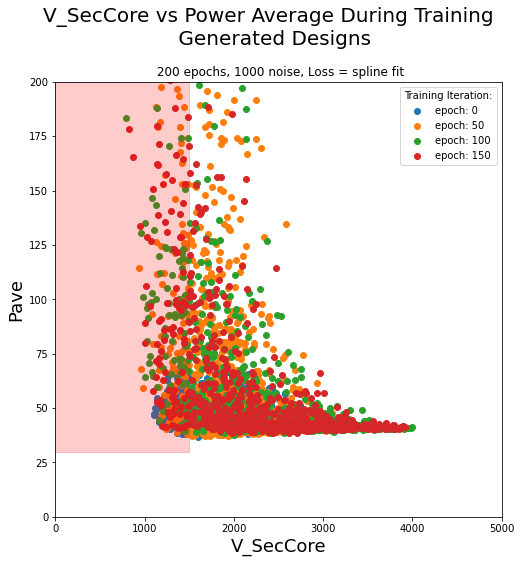

<Figure size 576x576 with 0 Axes>

In [44]:
i = 0
fig, ax = plt.subplots()

while i < len(V_SecCore_designs):

    ax.scatter(V_SecCore_designs[i], pave_designs[i], label = f"epoch: {i*50}")
    i+=1

plt.xlim(0,5000)
plt.ylim(0, 200)
plt.legend(title='Training Iteration:')
plt.xlabel("V_SecCore", fontsize = 18)
plt.ylabel('Pave', fontsize = 18)
plt.suptitle(f"V_SecCore vs Power Average During Training \n Generated Designs" , fontsize = 20, y=1.01)

plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")

rect = patches.Rectangle((0,30), 1500, 200, alpha = 0.2, ec = "Crimson", fc = "Red", visible = True)
ax.add_patch(rect)
plt.rcParams["figure.figsize"] = (8,8)
plt.figure(figsize=(8, 8))
plt.show()

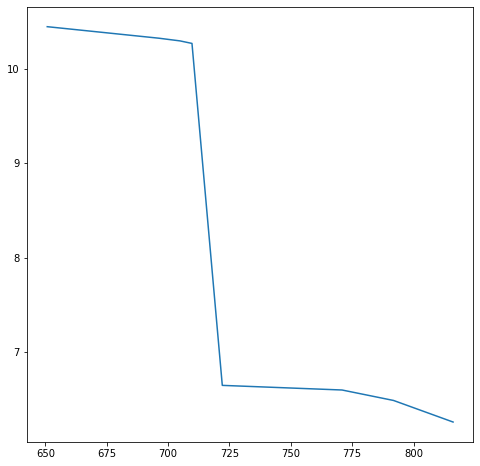

In [38]:
noise = generate_noise(shape=(10_000, 10))
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)

pareto_bstray, pareto_kdiff = pareto_frontier(bstray, kdiff)
pareto_kdiff = pareto_kdiff * 100

plt.plot(pareto_bstray.detach().cpu(), pareto_kdiff.detach().cpu())

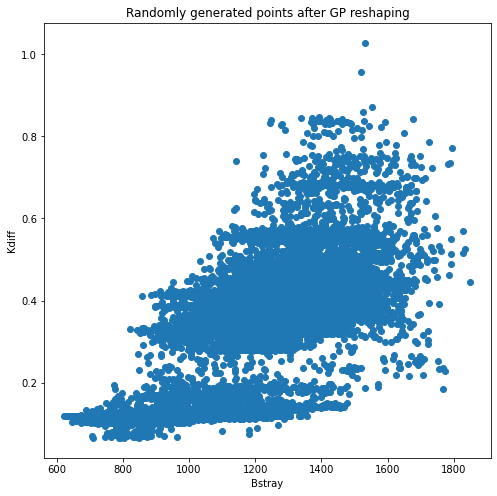

In [39]:
noise = generate_noise(shape=(25_000, 10))
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)

plt.scatter(bstray.detach().cpu(), kdiff.detach().cpu())
plt.title("Randomly generated points after GP reshaping")
plt.xlabel("Bstray")
plt.ylabel("Kdiff")
plt.show()

In [40]:
noise = generate_noise(shape=(3, 10))
gp = gp_model(noise)

noise = noise.cpu().numpy()
gp = gp.cpu().detach().numpy()

for i in range(3):
    print(f"Noise {i}")
    print(noise[i])
    print()
    print(f"Generated Parameters {i}")
    print(gp[i])
    print()

Noise 0
[ 0.04101419  0.34708083 -0.22188711  0.5275893   0.01459944 -0.6676489
  0.20969105 -0.9354551  -0.11613619  0.574291  ]

Generated Parameters 0
[0.6728342  0.76642454 0.67323554 0.49700066 0.38120773 0.74987733
 0.71334994 0.51068175 0.44691524 0.3693751 ]

Noise 1
[ 0.9502919  -0.84337425  0.8520248   0.37778485  0.7457894  -0.50416434
  0.30488837  0.677212   -0.88005257  0.4952891 ]

Generated Parameters 1
[0.6848593  0.71806866 0.9225133  0.6557332  0.7800792  0.8705411
 0.5553367  0.26441512 0.60272783 0.46327987]

Noise 2
[-0.66146374  0.88239443  0.8194696  -0.23779678  0.73123753  0.3056749
  0.5584065   0.11068308  0.46339512  0.3499174 ]

Generated Parameters 2
[0.2185045  0.09542474 0.03316803 0.3031584  0.26771888 0.0468093
 0.2716334  0.7267838  0.49590957 0.6811479 ]



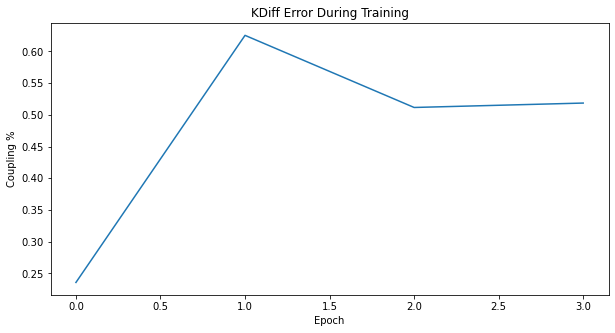

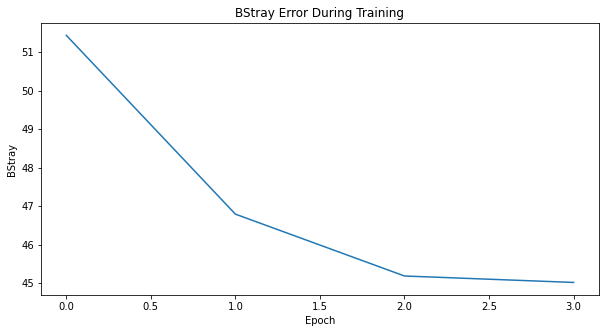

In [41]:
plt.figure(figsize=(10, 5))
plt.title(f"KDiff Error During Training")
plt.xlabel("Epoch")
plt.ylabel("Coupling %")

plt.plot(numpy.arange(len(kdiffs)), kdiffs)
plt.show()


plt.figure(figsize=(10, 5))
plt.title(f"BStray Error During Training")
plt.xlabel("Epoch")
plt.ylabel("BStray")

plt.plot(numpy.arange(len(bstrays)), bstrays)
plt.show()